## Predicting Default rate through ensemble learning 
In this script, we attempt to determine whether to lend a customer money by first predicting the loan default probability based on the loan info and customer's demographic info, and then calculate and implement the optimal threshold that maximizes expected revenue.
We performed stacking on five binary classifcation models, which consist of two logistic regression models, a decision tree classifier, a xgboost model， and a lightGBM model.Stacking is an ensemble learning method that predicts the default rate of the customer by the predicted default rate from all the models.  
The finary stacking model that we chose in the mean probability predicted by the five models, because it has the highest AUC.
The threshold (0.83) for determining whether to lend is determined by finding the threshold that creates the highest expected earning, assuming that the defaulter does not pay any interest or principal, that the interest rates for all loans are simple interest rates, and that the borrowers would take exactly the time length of the loan term to repay their loans.
Ideally, if we have data on the time of the default, we could calculate the monthly default rate for a loan, allowing us to determine more accurately the threshold that optimizes the expected profit from a customer.

Catalog of the script:

1. Drop columns to prevent data leakage.
2. Drop the lesser predictive features among highly correlated features to prevent mutlicollinearity
3. Split training and testing set
4. Fill na by fitting target encoder and mean value imputator on the training set, and the use them on the testing set.
5. Transform employment title and short purpose statement into topic features through LDA to reduce dimensions of employment title.
6. One-hot encoding
7. Check for multicollinearity again after one-hot encoding and adding topic features
8. (attempted to create 75 interaction terms interaction terms that are highly correlated with the target variable, but stopped because of the fear of computational pressure on the hardware)
9. Oversample
9. Fit a logistic regression with L1 regularization
10. Fit a logistic regression with L2 regularization
11. Fit a decision tree with randomsearch for hyperparameter optimization
12. Fit a XGBoost with randomsearch for hyperparameter optimization
13. Fit a lightGBM with randomsearch for hyperparameter optimization
14. Stack the results of the 5 models through logistic regression
15. Stack the results of the 5 models through decision tree
16. Stack the results of the 5 models by computing means







Key words:
1. Hyperparameter tuning
2. Missing data imputation
3. Stacking
4. Machine learning
5. Binary classification



In [20]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [21]:
df = pd.read_csv("logistic_regression.txt")

## Preventing signal leakage

Since our purpose is to decide whether to hand out loans. We should first delete features that are not available before the loan is issued. Therefore, we shoulde delete variables such as grade and interest_rate

In [22]:
df = df.drop(['int_rate', 'grade', 'sub_grade','installment','issue_d'], axis = 1)

# Data investigation:



Extrat zip code

Extract zip code from address. Zip code could be strongly indicative of a person's social economic status. We will drop address right after, since we do not have enough data to know how well a particular street would perform econimcally. 

In [23]:
df['zip_code']= [address[-5:] for address in df['address']]

In [24]:
df = df.drop('address', axis = 1)

checking missing values

In [25]:
def check_miss(df):
    return (df.isna().sum()/df.shape[0]) *100


check_miss(df)


loan_amnt                  0.000000
term                       0.000000
emp_title                  5.789208
emp_length                 4.621115
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
loan_status                0.000000
purpose                    0.000000
short_purpose_statement    0.443401
dti                        0.000000
earliest_cr_line           0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.069692
total_acc                  0.000000
initial_list_status        0.000000
application_type           0.000000
mort_acc                   9.543469
pub_rec_bankruptcies       0.135091
zip_code                   0.000000
dtype: float64

In [26]:
df["loan_status"].value_counts(normalize=True)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: proportion, dtype: float64

- #### As we can see, there is an imbalance in the data. We will need oversampling later on in this script

In [27]:
lis = [1,2,3]
lis2 = [1,2,3,4]
print(dict(zip(lis,lis2)))

{1: 1, 2: 2, 3: 3}


## Filling na home_owernership

In [28]:
df["home_ownership"].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

In [29]:
df["home_ownership"].replace({"ANY":"OTHER",
                             "NONE":"OTHER"},
                            inplace=True)

In [31]:
print(df["short_purpose_statement"].nunique())
print(df["emp_title"].nunique())

48816
173105


There are many short purpose statements and employment title. We would certainly cause over fitting if we use them all for predictions. Therefore, later in the script, right after tran-test splitting, we will use lda to reduce the dimensions of the employment titles and short purpose statements into different topics to reduce dimensions.

## Filling na emp_length

We can see that loans without the borrower's employment length is indicative of high default rate. Therefore, we should make 'no employment info' as a category.

In [32]:
# emp_good = pd.DataFrame(encoding_set.groupby('emp_length', dropna = False)['loan_status'].agg(['sum', 'count'], dropna=False))
# pd.DataFrame(emp_good['sum']/emp_good['count']).sort_values(0)

In [33]:
df['emp_length'] = df['emp_length'].fillna('none')

#### Changing date columns into days after months after 1900" 

In [34]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [35]:
df['earliest_cr_line']  = (df['earliest_cr_line'] .dt.year - 1900) * 12 + df['earliest_cr_line'] .dt.month

Deleting outliers

<Axes: xlabel='earliest_cr_line', ylabel='Density'>

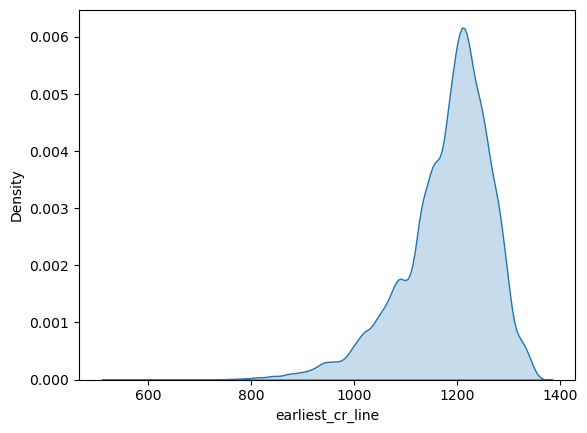

In [36]:
sns.kdeplot(df['earliest_cr_line'] , shade=True)


In [37]:
df = df[df['earliest_cr_line'] > 700]

## Changing the format of target variable : 



## Converting target values : 
- ### if loanStatus is Fully Paid : 0
- ### if loanStatus is Charged Off : 1

In [38]:
df["loan_status"] = df["loan_status"].map({"Fully Paid":0,
                      "Charged Off":1})

### keeping an eye on missing values 

In [39]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt                  0.000000
term                       0.000000
emp_title                  5.786005
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
loan_status                0.000000
purpose                    0.000000
short_purpose_statement    0.443193
dti                        0.000000
earliest_cr_line           0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.069699
total_acc                  0.000000
initial_list_status        0.000000
application_type           0.000000
mort_acc                   9.543675
pub_rec_bankruptcies       0.135104
zip_code                   0.000000
dtype: float64

In [40]:
df['emp_title'].nunique()

173093

In [41]:
df['mort_acc'].value_counts()

mort_acc
0.0     139765
1.0      60412
2.0      49945
3.0      38046
4.0      27882
5.0      18188
6.0      11067
7.0       6051
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        36
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: count, dtype: int64

## Filling missing value :  target encoding

Target encoding requires fitting on the training set and applying on the testing set. In this mini section, we call the training set the encoding set

In [42]:
y = df['loan_status']
X = df.drop('loan_status', axis = 1)

In [43]:
X_train , X_test,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.3,
                                                      random_state=42)
encoding_set = pd.concat([X_train, y_train], axis = 1)
encoded_set =  pd.concat([X_test, y_test], axis = 1)
mort_means = encoding_set.groupby('total_acc')['mort_acc'].mean()
encoding_set['mort_acc'] = encoding_set['total_acc'].map(mort_means).fillna(0.5)
encoded_set['mort_acc'] = encoded_set['total_acc'].map(lambda x: mort_means[x] if x in mort_means else encoded_set['mort_acc'].mean())

mort_acc filled

### Target Encoding for "pub_rec_bankruptcies":

In [44]:
# df2["pub_rec_bankruptcies"].value_counts(dropna=False)

In [45]:
emp_good = pd.DataFrame(encoding_set.groupby('emp_length', dropna = False)['loan_status'].agg(['sum', 'count']))
pd.DataFrame(emp_good['sum']/emp_good['count']).sort_values(0)

,0
emp_length,
10+ years,0.184106
5 years,0.189615
6 years,0.190437
4 years,0.191759
2 years,0.192412
3 years,0.194719
7 years,0.194739
8 years,0.195352
1 year,0.195483


In [46]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

In [47]:
df["pub_rec_bankruptcies"] = df["pub_rec_bankruptcies"].fillna("Record_not_cound").astype("str")

In [48]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

pub_rec_bankruptcies
0.0                 350349
1.0                  42782
2.0                   1846
Record_not_cound       535
3.0                    351
4.0                     82
5.0                     32
6.0                      7
7.0                      4
8.0                      2
Name: count, dtype: int64

In [49]:
emp_good2 = pd.DataFrame(df.groupby('pub_rec_bankruptcies', dropna = False)['loan_status'].agg(['sum', 'count']))
pd.DataFrame(emp_good2['sum']/emp_good2['count']).sort_values(0)

,0
pub_rec_bankruptcies,
5.0,0.156250
Record_not_cound,0.162617
0.0,0.194988
1.0,0.203894
3.0,0.210826
2.0,0.232394
7.0,0.250000
6.0,0.285714
4.0,0.317073


In [50]:
df.groupby('pub_rec_bankruptcies', dropna = False)['loan_status'].agg(['sum', 'count'])

,sum,count
pub_rec_bankruptcies,,
0.0,68314,350349
1.0,8723,42782
2.0,429,1846
3.0,74,351
4.0,26,82
5.0,5,32
6.0,2,7
7.0,1,4
8.0,1,2


In [51]:
encoding_set["pub_rec_bankruptcies"] = encoding_set["pub_rec_bankruptcies"].astype(str)
encoded_set["pub_rec_bankruptcies"] = encoded_set["pub_rec_bankruptcies"].astype(str)

In [52]:
TE.fit(encoding_set["pub_rec_bankruptcies"],encoding_set["loan_status"])
encoding_set["pub_rec_bankruptcies"] = TE.transform(encoding_set["pub_rec_bankruptcies"])
encoded_set["pub_rec_bankruptcies"] = TE.transform(encoded_set["pub_rec_bankruptcies"])

In [53]:
df2 = pd.concat([encoding_set, encoded_set], axis = 0)
df2 = df2.sort_index()

In [54]:
df2["pub_rec_bankruptcies"].value_counts(dropna=False)

pub_rec_bankruptcies
0.194127    350349
0.202605     42782
0.229902      1846
0.163683       535
0.230769       351
0.341051        82
0.203077        32
0.162440         7
0.216567         4
0.299942         2
Name: count, dtype: int64

In [55]:
df = df2.copy()

In [56]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt                  0.000000
term                       0.000000
emp_title                  5.786005
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
purpose                    0.000000
short_purpose_statement    0.443193
dti                        0.000000
earliest_cr_line           0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.069699
total_acc                  0.000000
initial_list_status        0.000000
application_type           0.000000
mort_acc                   0.000000
pub_rec_bankruptcies       0.000000
zip_code                   0.000000
loan_status                0.000000
dtype: float64

In [57]:
df.shape

(395990, 22)

## Use LDA (Latent Dirichlet Allocation) to numerify short purpose statements and employment title. title into several topic columns

A loan borrow's employment title and reason for borrowing money can be important predictors and whether the borrower would default.  Therefore, we should not drop the two columns, but quantify them through natural language processing.

In [287]:
encoding_set['short_purpose_statement'].nunique()

35992

In [59]:
encoding_set['emp_title'] = encoding_set['emp_title'].fillna('nan')

In [60]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
import nltk
nltk.download('wordnet')
nltk.download('omw')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jiadiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\jiadiz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jiadiz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
import nltk
nltk.download('wordnet')


# Preprocess the text data
docs = encoding_set['emp_title'].tolist()

# Tokenize the sentences
tokenized_docs = [[word for word in document.lower().split() if word.isalpha()] for document in docs]

# Remove stop words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
tokenized_docs = [[word for word in document if word not in stop_words] for document in tokenized_docs]

# Stem or lemmatize the words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_docs = [[lemmatizer.lemmatize(word) for word in document] for document in tokenized_docs]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jiadiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
# Create a gensim Dictionary object
dictionary = corpora.Dictionary(tokenized_docs)

# Convert tokenized documents into a bag of words representation
corpus = [dictionary.doc2bow(document) for document in tokenized_docs]


In [64]:
# Train the LDA model
lda_model_emp = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)


In [65]:
# Transform the corpus into a matrix of topic probabilities
topic_probs = np.zeros((len(corpus), 10))

for i, doc in enumerate(corpus):
    for topic, prob in lda_model_emp[doc]:
        topic_probs[i][topic] = prob


In [66]:
# Add topic probabilities as new columns to the DataFrame
for i in range(10):
    encoding_set[f"Topic {i+1}"] = topic_probs[:, i]


In [67]:
# import joblib
# joblib.dump(lda_model_emp, 'lda_model_emp.joblib')

In [68]:
encoded_set['emp_title'] = encoded_set['emp_title'].fillna('nan')

In [69]:
encoded_set['emp_title'] = encoded_set['emp_title'].fillna('nan')

new_docs = encoded_set['emp_title'].tolist()

# Tokenize the sentences
new_tokenized_docs = [[word for word in document.lower().split() if word.isalpha()] for document in new_docs]

# Remove stop words
new_tokenized_docs = [[word for word in document if word not in stop_words] for document in new_tokenized_docs]

# Stem or lemmatize the words
new_tokenized_docs = [[lemmatizer.lemmatize(word) for word in document] for document in new_tokenized_docs]

# Convert tokenized documents into a bag of words representation
new_corpus = [dictionary.doc2bow(document) for document in new_tokenized_docs]

# Transform the new corpus into a matrix of topic probabilities
new_topic_probs = np.zeros((len(new_corpus), 10))

for i, doc in enumerate(new_corpus):
    for topic, prob in lda_model_emp[doc]:
        new_topic_probs[i][topic] = prob

# Add topic probabilities as new columns to the new DataFrame
for i in range(10):
    encoded_set[f"Topic {i+1}"] = new_topic_probs[:, i]

Exercise the same lda modeling to the column short purpose statements

In [70]:
encoding_set['short_purpose_statement'] = encoding_set['short_purpose_statement'].fillna('nan')
encoded_set['short_purpose_statement'] = encoded_set['short_purpose_statement'].fillna('nan')

In [71]:

# Preprocess the text data
# Preprocess the text data
docs = encoding_set['short_purpose_statement'] .tolist()

# Tokenize the sentences
tokenized_docs = [[word for word in document.lower().split() if word.isalpha()] for document in docs]

# Remove stop words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
tokenized_docs = [[word for word in document if word not in stop_words] for document in tokenized_docs]

# Stem or lemmatize the words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_docs = [[lemmatizer.lemmatize(word) for word in document] for document in tokenized_docs]

dictionary = corpora.Dictionary(tokenized_docs)

# Convert tokenized documents into a bag of words representation
corpus = [dictionary.doc2bow(document) for document in tokenized_docs]

# Train the LDA model
lda_model_title = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Transform the corpus into a matrix of topic probabilities
topic_probs = np.zeros((len(corpus), 10))

for i, doc in enumerate(corpus):
    for topic, prob in lda_model_title[doc]:
        topic_probs[i][topic] = prob
        
# Add topic probabilities as new columns to the DataFrame
for i in range(10):
    encoding_set[f"short_purpose_statement_Topic {i+1}"] = topic_probs[:, i]



In [72]:

# joblib.dump(lda_model_title, 'lda_model_title.joblib')

In [73]:
new_docs = encoded_set['short_purpose_statement'].tolist()

# Tokenize the sentences
new_tokenized_docs = [[word for word in document.lower().split() if word.isalpha()] for document in new_docs]

# Remove stop words
new_tokenized_docs = [[word for word in document if word not in stop_words] for document in new_tokenized_docs]

# Stem or lemmatize the words
new_tokenized_docs = [[lemmatizer.lemmatize(word) for word in document] for document in new_tokenized_docs]

# Convert tokenized documents into a bag of words representation
new_corpus = [dictionary.doc2bow(document) for document in new_tokenized_docs]

# Transform the new corpus into a matrix of topic probabilities
new_topic_probs = np.zeros((len(new_corpus), 10))

for i, doc in enumerate(new_corpus):
    for topic, prob in lda_model_title[doc]:
        new_topic_probs[i][topic] = prob

# Add topic probabilities as new columns to the new DataFrame
for i in range(10):
    encoded_set[f"short_purpose_statement_Topic {i+1}"] = new_topic_probs[:, i]

In [74]:
df3 = pd.concat([encoding_set, encoded_set],axis = 0).reset_index()

In [75]:
check_miss(df3)

index                               0.000000
loan_amnt                           0.000000
term                                0.000000
emp_title                           0.000000
emp_length                          0.000000
home_ownership                      0.000000
annual_inc                          0.000000
verification_status                 0.000000
purpose                             0.000000
short_purpose_statement             0.000000
dti                                 0.000000
earliest_cr_line                    0.000000
open_acc                            0.000000
pub_rec                             0.000000
revol_bal                           0.000000
revol_util                          0.069699
total_acc                           0.000000
initial_list_status                 0.000000
application_type                    0.000000
mort_acc                            0.000000
pub_rec_bankruptcies                0.000000
zip_code                            0.000000
loan_statu

## Dropping rest of the missing values : 

In [76]:
outlier_set = df3[['index', 'loan_amnt', 'term', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'short_purpose_statement', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'loan_status']]

In [77]:
list[outlier_set.columns]

list[Index(['index', 'loan_amnt', 'term', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'short_purpose_statement', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'loan_status'], dtype='object')]

In [78]:
df3.dropna(inplace=True)

### Outlier Detection & Treatment  : 

In [79]:
numerical_data = outlier_set.select_dtypes(include='number')

In [80]:
# Calculate the mean and standard deviation of the DataFrame
mean = numerical_data.mean()
std = numerical_data.std()

# Calculate the absolute deviation from the mean
deviation = np.abs(numerical_data- mean)

# Calculate the number of rows where at least one value is 3 standard deviations away from the mean
final_data_without_topics = numerical_data[deviation < 3* std].dropna()



In [81]:
num_cols = final_data_without_topics.columns 

In [82]:

# def box_plot(col):
#     plt.figure(figsize=(8, 5))
#     sns.kdeplot(x=removed_ooutlier[col])
#     plt.title('Boxplot')
#     plt.show()

# for col in num_cols:
#     box_plot(col)


In [83]:
final_data_without_topics['loan_status']

0         0
1         0
2         0
3         1
4         0
         ..
395985    0
395986    1
395987    0
395988    0
395989    0
Name: loan_status, Length: 368822, dtype: int64

In [88]:
new_cols = list(set(df3.columns) - set(final_data_without_topics.columns))

# select only the columns that are not in final_data_without_topics
new_data = df3[new_cols]

In [89]:
# join the data frames using their indices
semi_final = final_data_without_topics.join(new_data)

# drop the duplicate columns from df2

## Data Preprocessing -

In [90]:

semi_final['term'] = semi_final.term.map({' 36 months': 36, ' 60 months': 60})

semi_final['initial_list_status'] = semi_final.initial_list_status.map({'w': 0, 'f': 1})

## One-hot-encoding for other categorical data : 

In [93]:
semi_final = semi_final.drop(['emp_title','short_purpose_statement'], axis = 1)

In [94]:
to_be_dummied = list(semi_final.select_dtypes(include='object').columns)

In [95]:

semi_quarter_final = pd.get_dummies(semi_final,columns=to_be_dummied,drop_first=True)

In [96]:
semi_quarter_final['loan_status']

0         0
1         0
2         0
3         1
4         0
         ..
395985    0
395986    1
395987    0
395988    0
395989    0
Name: loan_status, Length: 368822, dtype: int64

<Axes: >

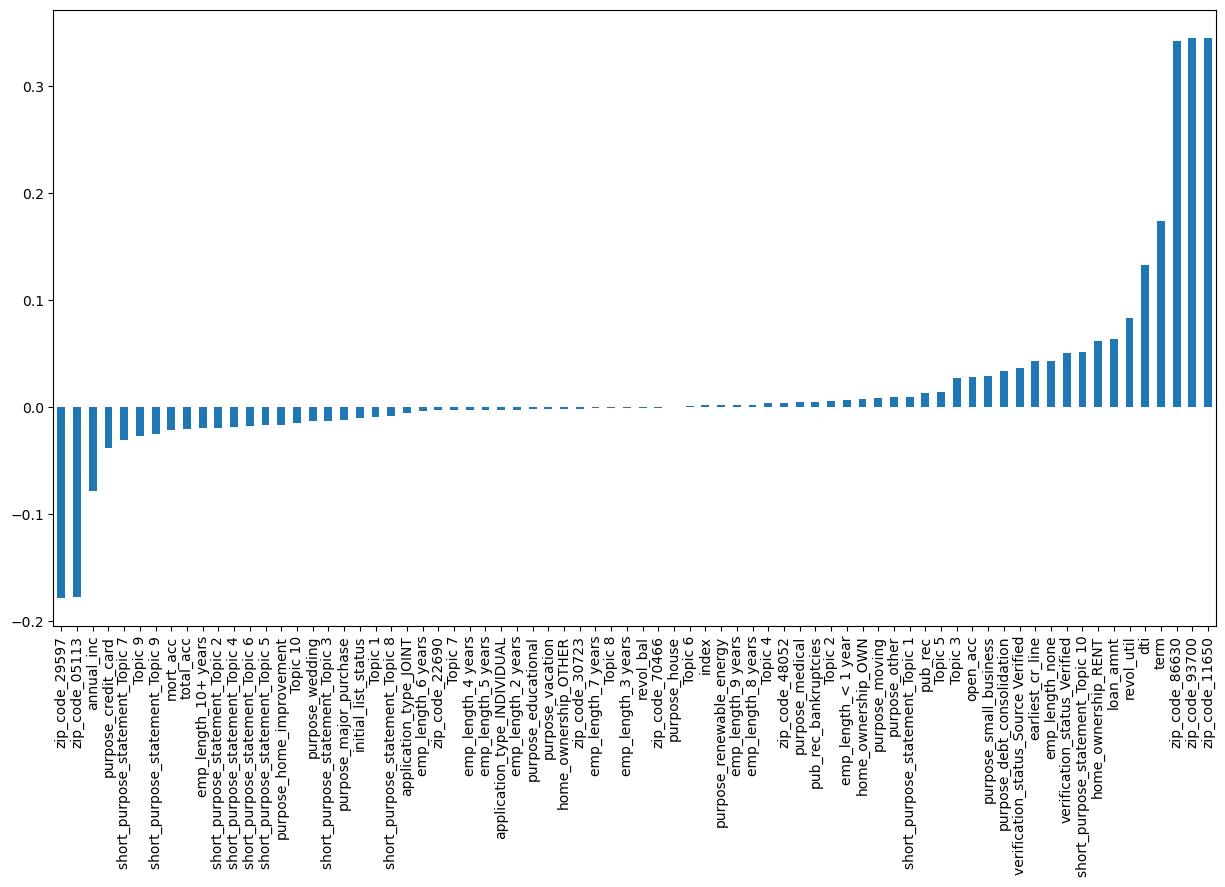

In [97]:
plt.figure(figsize=(15,8))

semi_quarter_final.corr()["loan_status"].sort_values()[:-1].plot(kind = "bar")

Subset the data with the highest correlation with loan status


# Data preparation for modeling: 

In [99]:
X = semi_quarter_final.drop("loan_status",axis = 1)
y = semi_quarter_final["loan_status"]

In [100]:
# X_selected.to_csv('X_selected.csv', index=False)
# y.to_csv('y.csv', index=False)
# X_selected

In [101]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t

import warnings

In [102]:
X_selected = X
X_selected = X_selected.drop('index', axis = 1)

In [103]:
# feature_selection_data_set = pd.concat([X_selected,y], axis = 1)

In [104]:
# corr_matrix = feature_selection_data_set.corr()

In [105]:
# Find the highly correlated features
# high_corr_features = np.where(corr_matrix > 0.8)

# high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y])
#                       for x, y in zip(*high_corr_features)
#                       if x != y and x < y]

In [106]:
# for feature1, feature2 in high_corr_features:
#     corr1 = abs(corr_matrix.loc[feature1, 'loan_status'])
#     corr2 = abs(corr_matrix.loc[feature2, 'loan_status'])
#     if corr1 > corr2:
#         print(feature2)
#         feature_selection_data_set = feature_selection_data_set.drop(feature2, axis=1)
#     else:
#         print(feature1)
#         feature_selection_data_set = feature_selection_data_set.drop(feature1, axis=1)


In [107]:
# X = feature_selection_data_set.drop('loan_status',axis = 1)
# y = feature_selection_data_set['loan_status']

In [108]:
# exp_data = pd.read_csv('X_selected.csv')
# exp_data = exp_data.iloc[:,:74]

In [109]:
# exp_data.drop('index', axis = 1).columns[~exp_data.drop('index', axis = 1).columns.isin(list(X.columns))]

### train-test-Split : 

In [110]:
from sklearn.model_selection import train_test_split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.45, random_state=42)

# split the testing data into 50% validation and 50% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [112]:
X_train.shape,X_test.shape

((202852, 73), (82985, 73))

In [113]:
X_train_non_scalled = X_train.copy()

In [114]:
X_valid_non_scalled = X_valid.copy()

In [115]:
X_test_non_scalled = X_test.copy()

## Scaling the data : 


In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
X_train = scaler.transform(X_train)

In [119]:
X_valid = scaler.transform(X_valid)

In [120]:
X_test = scaler.transform(X_test)

## Logistic Regression : 

### Handling Data Imbalance : 

In [121]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, np.array(y_train).ravel())


In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

logistic = LogisticRegression(
    penalty='l1',         
    dual=False,
    tol=0.001,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='saga',
    max_iter=10000,         
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None)

In [123]:
# Define the parameter grid to search over
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a GridSearchCV object to search over the parameter grid
grid_search = GridSearchCV(logistic, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_smote, y_smote)

# Print the best parameter and best score
print("Best parameter: ", grid_search.best_params_)

print("Best score: ", grid_search.best_score_)

Best parameter:  {'C': 0.01}
Best score:  0.8004912728744967


In [126]:
from sklearn.calibration import CalibratedClassifierCV

   
from sklearn.metrics import roc_auc_score,roc_curve

logistic_l1 = CalibratedClassifierCV(grid_search.best_estimator_, cv='prefit')

# Fit the CalibratedClassifierCV object to the training data
logistic_l1.fit(X_smote, y_smote)

# Get the predicted probabilities for the test set
probabilities = logistic_l1.predict_proba(X_smote)


In [127]:
roc_auc_score(y_smote, probabilities[:,1])

0.9048713314145149

In [128]:
import pickle

# assume your model is called `my_model`
# save the trained model to a file
with open('logistic_l1.pkl', 'wb') as f:
    pickle.dump(logistic_l1, f)

In [129]:
print(roc_auc_score(y_smote, logistic_l1.predict_proba(X_smote)[:,1]))
print(roc_auc_score(y_valid, logistic_l1.predict_proba(X_valid)[:,1]))
print(roc_auc_score(y_test, logistic_l1.predict_proba(X_test)[:,1]))

0.9048713314145149
0.8963016389655942
0.8990168226653676


In [137]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

# precision_recall_curve_plot(y_test, LogReg.predict_proba(X_test)[:,1])

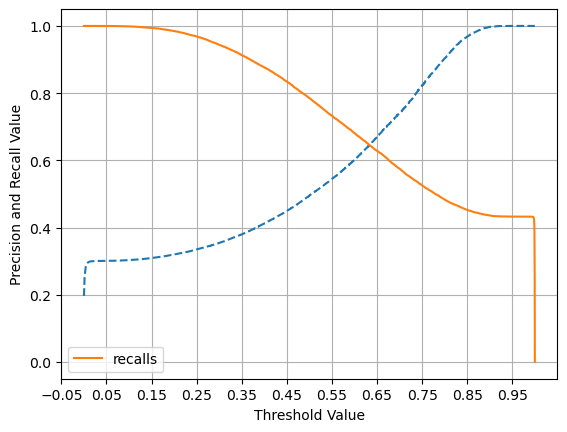

None
Precision at theshold 0.5 is :  0.49489756474681096



fbeta score : beta : 0.5 0.5343979831203198
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     66676
           1       0.49      0.79      0.61     16309

    accuracy                           0.80     82985
   macro avg       0.72      0.79      0.74     82985
weighted avg       0.85      0.80      0.82     82985

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

In [181]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report


threshold = 0.5
y_predicted = logistic_l1.predict(X_test)



print(precision_recall_curve_plot(y_test, logistic_l1.predict_proba(X_test)[:,1]))
plt.show()
    

print(f"Precision at theshold {threshold} is : ",precision_score(y_test,y_predicted))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = y_predicted,
                                                    beta = 0.5))
print(classification_report(y_test, y_predicted))

    
    
print("Feature Importance : ")
plt.figure(figsize=(15,8))

plt.show()

<Axes: xlabel='0'>

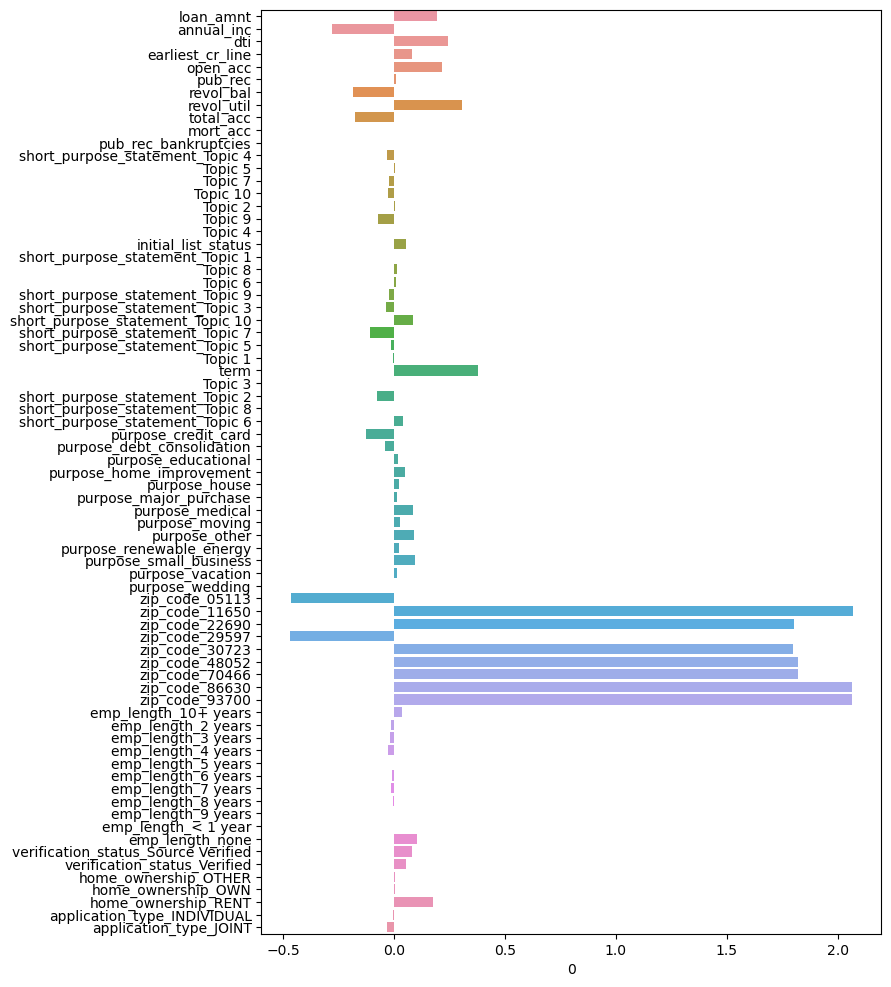

In [219]:
logistic_l1 = grid_search.best_estimator_
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X_selected.columns,data= logistic_l1.coef_).T[0],
           y =pd.DataFrame(columns=X_selected.columns,data= logistic_l1.coef_).T.index)

In [185]:
from sklearn.linear_model import LogisticRegression
logistic_l2 = LogisticRegression(
    penalty='l2',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    C=100.0,             # 1/lambda : 
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=10000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,)

# Define the parameter grid to search over
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a GridSearchCV object to search over the parameter grid
grid_search_l2 = GridSearchCV(logistic_l2, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search_l2.fit(X_smote, y_smote)

# Print the best parameter and best score

logistic_l2 = CalibratedClassifierCV(grid_search_l2.best_estimator_, cv='prefit')

# Fit the CalibratedClassifierCV object to the training data
logistic_l2.fit(X_smote, y_smote)

# Get the predicted probabilities for the test set


CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=100, max_iter=10000))

[[4.41321065e-01 5.58678935e-01]
 [1.00000000e+00 1.12128420e-11]
 [1.00000000e+00 5.59025838e-22]
 [1.00000000e+00 1.69144262e-21]
 [3.49508028e-01 6.50491972e-01]]
LR train score: 0.8007887006065513
LR test score: 0.799650539254082

Confusion Matrix: 
[[53533 13143]
 [ 3483 12826]]


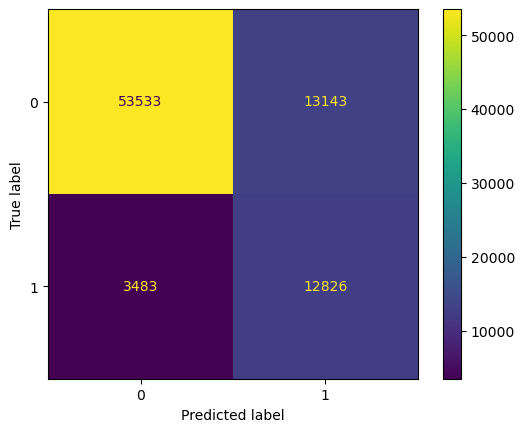

fbeta score : beta : 0.5
0.533594042517785
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     66676
           1       0.49      0.79      0.61     16309

    accuracy                           0.80     82985
   macro avg       0.72      0.79      0.74     82985
weighted avg       0.85      0.80      0.81     82985

Precision at theshold 0.83 is :  0.9587244438729587



fbeta score : beta : 0.5 0.7862159141236266
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     66676
           1       0.96      0.46      0.62     16309

    accuracy                           0.89     82985
   macro avg       0.92      0.73      0.78     82985
weighted avg       0.90      0.89      0.87     82985



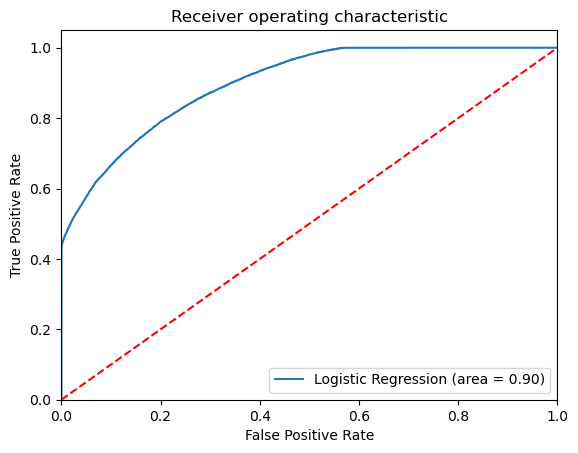

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [187]:
probabilities = logistic_l2.predict_proba(X_test)

# Print the first five rows of the predicted probabilities
print(probabilities[:5])


logistic_l2.fit(X_smote,y_smote)
print("LR train score:",logistic_l2.score(X_smote,y_smote))
print("LR test score:",logistic_l2.score(X_test ,y_test))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_predicted = logistic_l2.predict(X_test)

print()
print("Confusion Matrix: ")
print(confusion_matrix(y_test ,y_predicted ))

ConfusionMatrixDisplay(confusion_matrix(y_test ,y_predicted ),
                      display_labels=[0,1]).plot()

plt.show()

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print("fbeta score : beta : 0.5")
print(fbeta_score(y_true = y_test,
    y_pred = y_predicted,
    beta = 0.5))



print(classification_report(y_test, y_predicted))


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve

# print(precision_recall_curve_plot(y_test, logistic_l2.predict_proba(X_test)[:,1]))
plt.show()



def custom_predict(X, threshold):
        probs = logistic_l2.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))
threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))

logit_roc_auc = roc_auc_score(y_test, logistic_l2.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logistic_l2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
    

Feature Importance : 


<Axes: xlabel='0'>

<Figure size 1500x800 with 0 Axes>

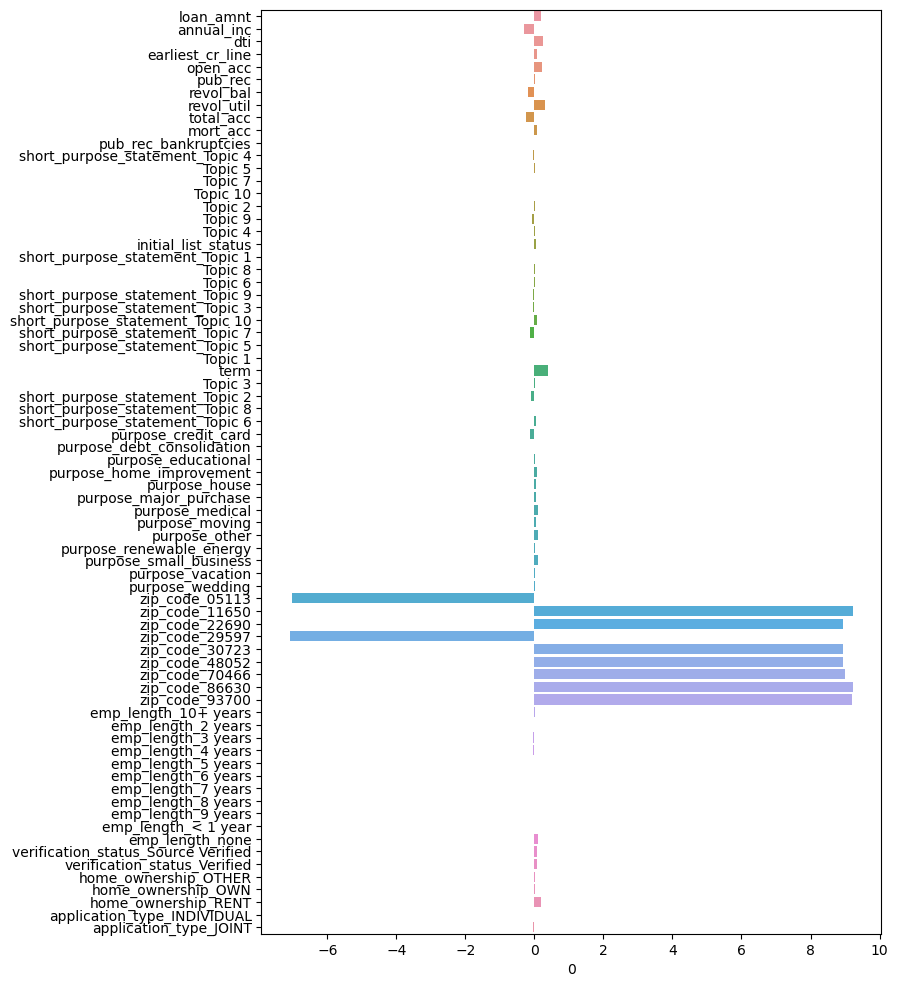

In [220]:
logistic_l2 = grid_search_l2 .best_estimator_
print("Feature Importance : ")
plt.figure(figsize=(15,8))


plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X_selected.columns,data= logistic_l2.coef_).T[0],
           y =pd.DataFrame(columns=X_selected.columns,data= logistic_l2.coef_).T.index)

In [189]:
print(roc_auc_score(y_smote, logistic_l2.predict_proba(X_smote)[:,1]))
print(roc_auc_score(y_valid, logistic_l2.predict_proba(X_valid)[:,1]))
print(roc_auc_score(y_test, logistic_l2.predict_proba(X_test)[:,1]))


0.9049197027158354
0.8962608316396575
0.8989293356799934


## XGBoost GBDT

In [193]:
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


In [195]:
xgbc = XGBClassifier()
param_dist = {
    'max_depth': sp_randint(3, 10),
    'min_child_weight': sp_randint(1, 20),
    'learning_rate': sp_uniform(0.001, 0.1),
    'n_estimators': sp_randint(100, 1000),
    'subsample': sp_uniform(0.5, 0.5),
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'gamma': sp_uniform(0, 2),
    'reg_alpha': sp_uniform(0, 2),
    'reg_lambda': sp_uniform(0, 2)
}

# Perform the random search
random_search = RandomizedSearchCV(
    xgbc,
    param_distributions=param_dist,
    n_iter=25,  # Adjust this to control the number of iterations
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_smote, y_smote)

# Show the best set of hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)

# Evaluate the best model on the test data
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best hyperparameters found:  {'colsample_bytree': 0.6872700594236812, 'gamma': 1.9014286128198323, 'learning_rate': 0.07419939418114051, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 221, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 0.11616722433639892, 'subsample': 0.9330880728874675}


In [250]:
xgb = CalibratedClassifierCV(best_xgb, cv='prefit')

# Fit the CalibratedClassifierCV object to the training data
xgb.fit(X_smote, y_smote)


CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_estimator='deprecated',
                                               base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               cv='prefit',
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               ensemble=True,
                                               estimator=XGBClassifier(base_score=None,
                                                                       booster=None,
                                                                       callbacks=None,
                                                                       colsam...
                                               estimator__enable_categorical=False,
                                               estimator__eval_metric=None,
                                               estimator__feature_types=None,
                                               estimator__gamma=1.9014286128198323,
                                               estimator__gpu_id=None,
                                               estimator__grow_policy=None,
                                               estimator__importance_type=None,
                                               estimator__interaction_constraints=None,
                                               estimator__learning_rate=0.07419939418114051,
                                               estimator__max_bin=None,
                                               estimator__max_cat_threshold=None, ...))

In [251]:
print(roc_auc_score(y_smote, xgb.predict_proba(X_smote)[:,1]))
print(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:,1]))
print(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

0.9813283787579662
0.895844556035473
0.898229414047954


In [208]:
xgb_ruc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1])

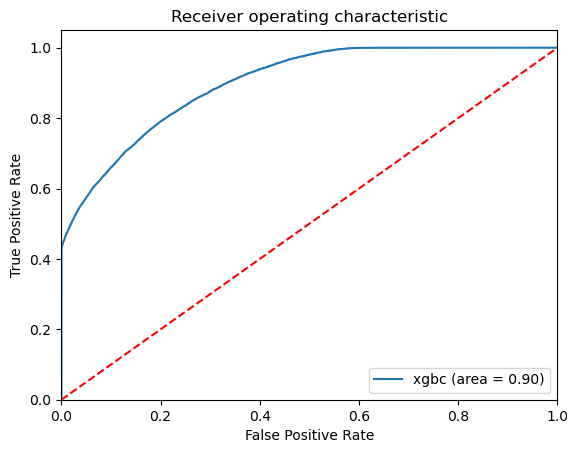

In [209]:
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % xgb_ruc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()


In [210]:
import pickle

# assume your model is called `my_model`
# save the trained model to a file
with open('best_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [248]:
base_estimator_params = best_xgb.get_params()

# Step 2: Create a new LightGBM model and set its parameters
# For classification tasks:
best_xgb = XGBClassifier(**base_estimator_params)


In [249]:
best_xgb.fit(X_smote, y_smote)

[15:32:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "base_estimator", "cv", "ensemble", "estimator", "estimator__colsample_bytree", "estimator__enable_categorical", "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__missing", "estimator__n_estimators", "estimator__objective", "estimator__reg_alpha", "estimator__reg_lambda", "estimator__subsample", "method" } are not used.



XGBClassifier(base_estimator='deprecated', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, cv='prefit', early_stopping_rounds=None,
              enable_categorical=False, ensemble=True,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsam...
              estimator__enable_categorical=False, estimator__eval_metric=None,
              estimator__feature_types=None,
              estimator__gamma=1.9014286128198323, estimator__gpu_id=None,
              estimator__grow_policy=None, estimator__importance_type=None,
              estimator__interaction_constraints=None,
              estimator__learning_rate=0.07419939418114051,
              estimator__max_bin=None, estimator__max_cat_threshold=None, ...)

## LightBGM

In [211]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
# Create a LightGBM model
model = lgb.LGBMClassifier()

# Specify the hyperparameter search space
param_dist = {
    'num_leaves': sp_randint(30, 150),
    'min_data_in_leaf': sp_randint(20, 200),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.001, 0.1),
    'n_estimators': sp_randint(100, 1100),
    'subsample': sp_uniform(0.5, 0.5),
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'reg_alpha': sp_uniform(0, 2),
    'reg_lambda': sp_uniform(0, 2)
}

# Perform the random search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,  # Adjust this to control the number of iterations
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_smote, y_smote)

# Show the best set of hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)

# Evaluate the best model on the test data
best_lgb = random_search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
Best hyperparameters found:  {'colsample_bytree': 0.9534142207728771, 'learning_rate': 0.028213224938463535, 'max_depth': 13, 'min_data_in_leaf': 135, 'n_estimators': 1072, 'num_leaves': 134, 'reg_alpha': 0.6095625163160581, 'reg_lambda': 0.32931170628588347, 'subsample': 0.767044709687721}


In [252]:
lgbm = CalibratedClassifierCV(best_lgb, cv='prefit')

# Fit the CalibratedClassifierCV object to the training data
lgbm.fit(X_smote, y_smote)


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(colsample_bytree=0.9534142207728771,
                                                learning_rate=0.028213224938463535,
                                                max_depth=13,
                                                min_data_in_leaf=135,
                                                n_estimators=1072,
                                                num_leaves=134,
                                                reg_alpha=0.6095625163160581,
                                                reg_lambda=0.32931170628588347,
                                                subsample=0.767044709687721))

In [253]:
print(roc_auc_score(y_smote, lgbm.predict_proba(X_smote)[:,1]))
print(roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:,1]))
print(roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

0.9950822550194484
0.8971661346848694
0.8996708567367495


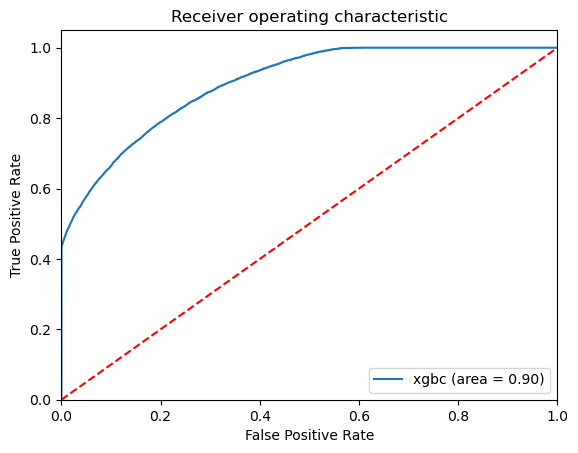

In [254]:

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



# def custom_predict(X, threshold):
#         probs = xgbc.predict_proba(X) 
#         return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
# threshold = 0.83

# new_preds = custom_predict(X=X_test, threshold=threshold)


# print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))
#

print()
print()

# print(precision_recall_curve_plot(y_test, xgbc.predict_proba(X_test)[:,1]))
# plt.show()



print()
# print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
#                                                 beta = 0.5))
# print(classification_report(y_test, new_preds))

lgbm_ruc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])



fpr, tpr, thresholds = roc_curve(y_test, lgbm.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % lgbm_ruc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()


In [217]:
import pickle

# assume your model is called `my_model`
# save the trained model to a file
with open('lgbm.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

#### Feature Importance according to Random Forest Model :

#### Feature Importance according to Logitistc Regression Model :

<Axes: xlabel='0'>

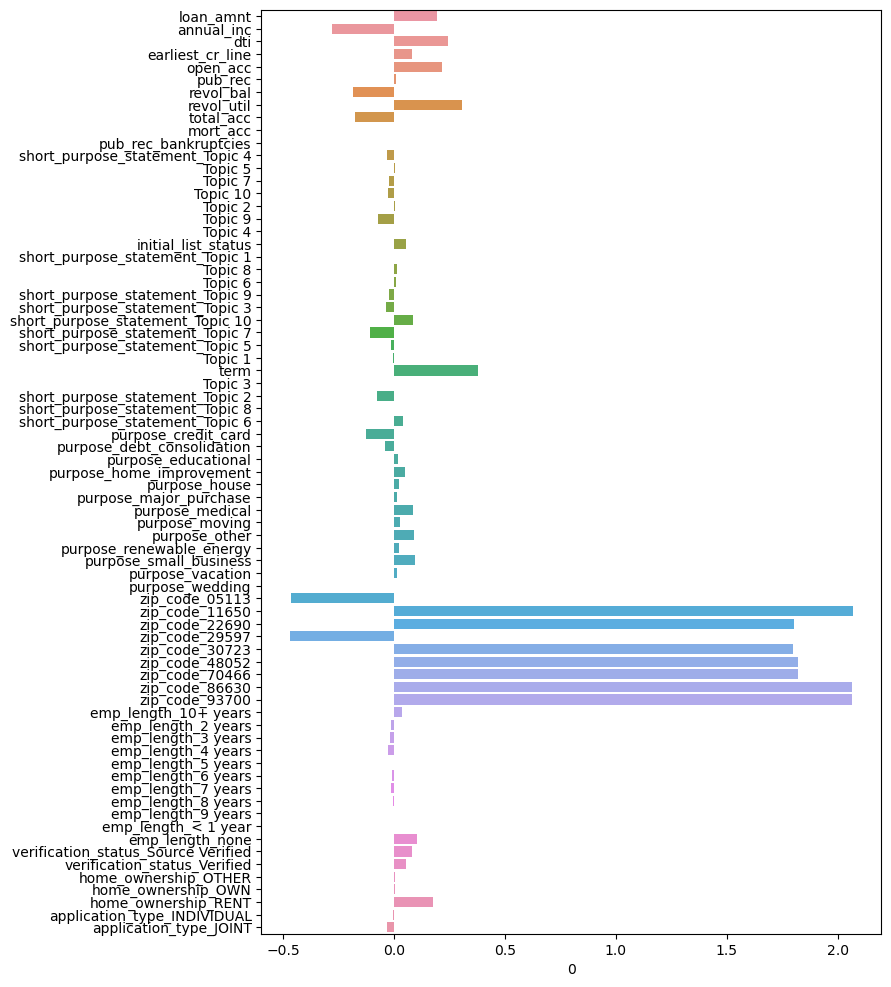

In [237]:
logistic_l1 = grid_search.best_estimator_
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X_selected.columns,data= logistic_l1.coef_).T[0],
           y =pd.DataFrame(columns=X_selected.columns,data= logistic_l1.coef_).T.index)


<Axes: xlabel='0'>

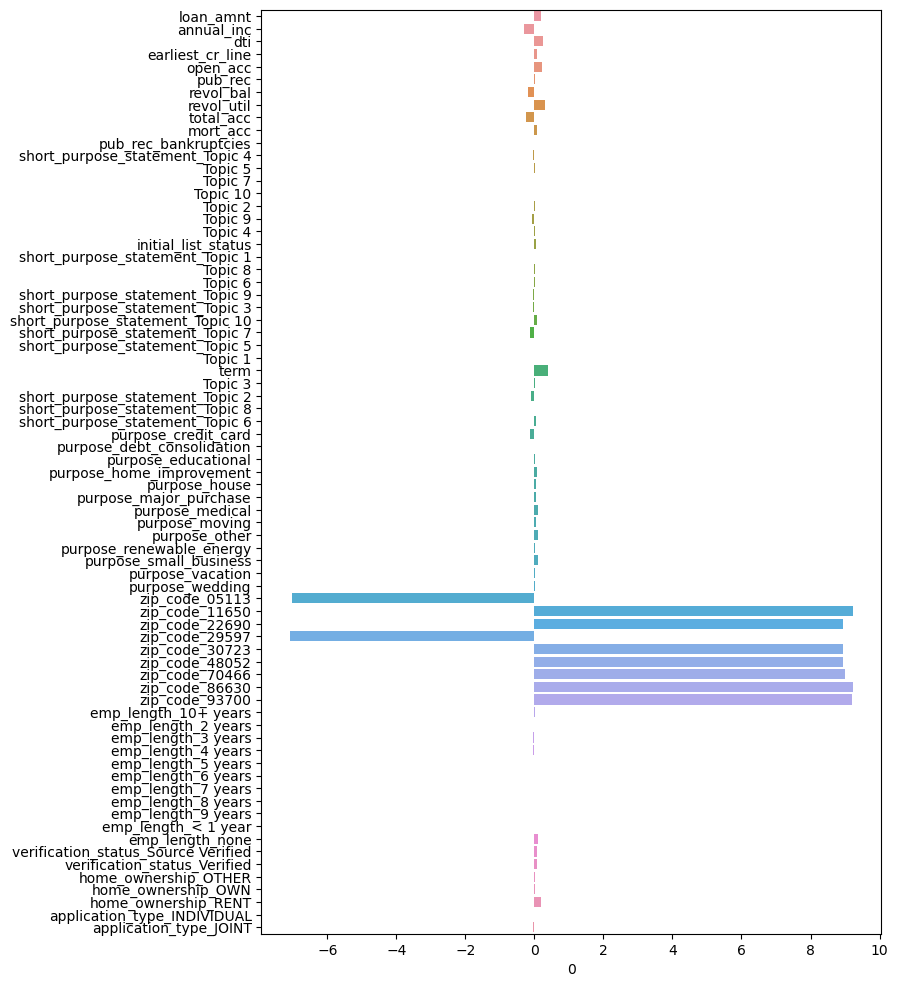

In [238]:

plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X_selected.columns,data= logistic_l2.coef_).T[0],
           y =pd.DataFrame(columns=X_selected.columns,data= logistic_l2.coef_).T.index)

#### Feature Importance according to XGBoost Classifier Model :

<Axes: xlabel='0'>

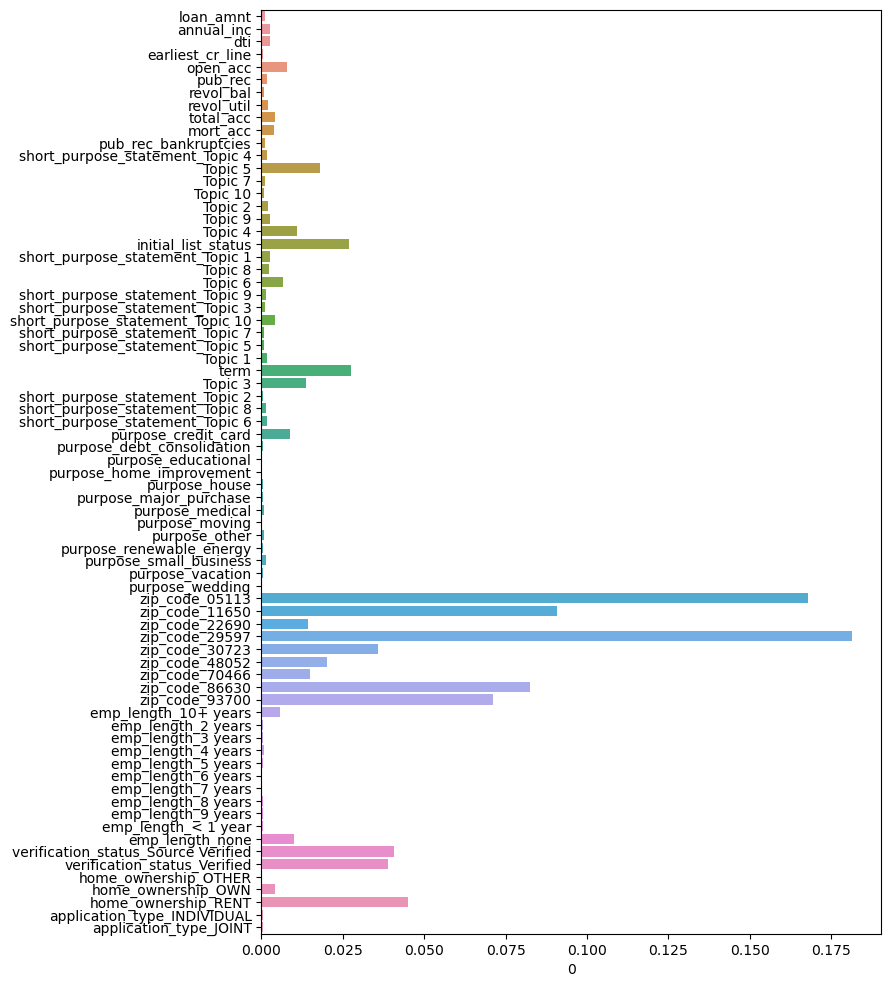

In [243]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X_selected.columns,data= xgb.feature_importances_)[0],
           y =pd.DataFrame(index=X_selected.columns,data= xgb.feature_importances_).index)


####  Feature Importance according to lgbm Classifier Model :

<Axes: xlabel='0'>

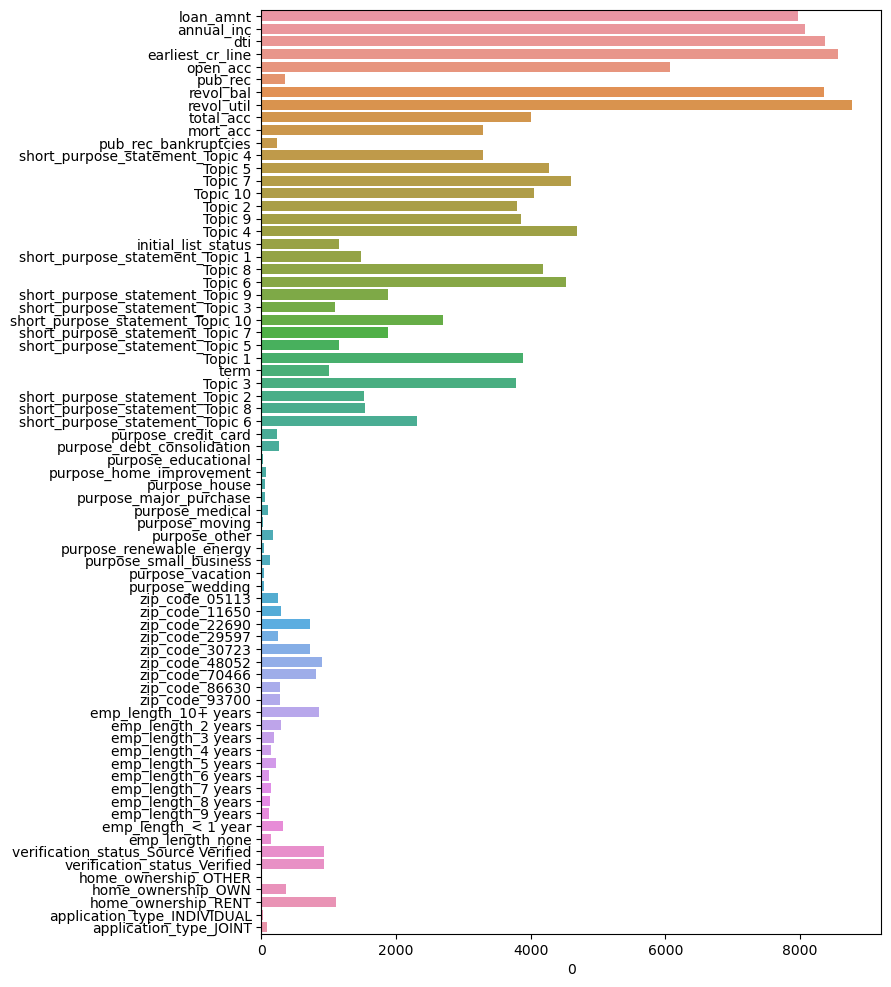

In [244]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X_selected.columns,data= best_lgb.feature_importances_)[0],
           y =pd.DataFrame(index=X_selected.columns,data= best_lgb.feature_importances_).index)

## Final stacking models

In [255]:
logistic_l1, logistic_l2, xgb, lgbm

(LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='saga',
                    tol=0.001),
 LogisticRegression(C=100, max_iter=10000),
 CalibratedClassifierCV(cv='prefit',
                        estimator=XGBClassifier(base_estimator='deprecated',
                                                base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                cv='prefit',
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                ensemble=True,
                                                estimator=XGBClassifier(base_score=None,
                 

In [257]:
train_model_predictions = pd.DataFrame({'logistic_l1':logistic_l1.predict_proba(X_smote)[:, 1],
'logistic_l2':logistic_l2.predict_proba(X_smote)[:, 1],
'xgb':xgb.predict_proba(X_smote)[:, 1],
'lgbm':lgbm.predict_proba(X_smote)[:, 1]})

In [258]:
valid_model_predictions = pd.DataFrame({'logistic_l1':logistic_l1.predict_proba(X_valid)[:, 1],
'logistic_l2':logistic_l2.predict_proba(X_valid)[:, 1],
'xgb':xgb.predict_proba(X_valid)[:, 1],
'lgbm':lgbm.predict_proba(X_valid)[:, 1]})

In [259]:
test_model_predictions = pd.DataFrame({'logistic_l1':logistic_l1.predict_proba(X_test)[:, 1],
'logistic_l2':logistic_l2.predict_proba(X_test)[:, 1],
'xgb':xgb.predict_proba(X_test)[:, 1],
'lgbm':lgbm.predict_proba(X_test)[:, 1]})

Fitting the outputs of the 4 models with a another logistic regression

In [260]:
from sklearn.linear_model import LogisticRegression
final_lr_model = LogisticRegression(
    penalty='elasticnet',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='saga',
    max_iter=10000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=0.5,)


params = {
    'C': np.logspace(-4, 4, 20)  # You can modify the range and the number of values as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(final_lr_model, params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the model using grid search
grid_search.fit(train_model_predictions, y_smote)

# Get the best C-value
best_c = grid_search.best_params_['C']
print(f"Best C-value: {best_c}")

# Get the best logistic regression model


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C-value: 0.012742749857031334


In [261]:

import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_logistic_regression = grid_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_logistic_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_logistic_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

# y_pred_prob = best_final_logistic_regression.predict_proba(train_model_predictions)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_threshold = thresholds[np.argmax(f1_scores)]
# print("Best probability threshold:", best_threshold)
best_threshold = 0.83

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_lr_train_pred = custom_predict(best_final_logistic_regression, train_model_predictions, best_threshold)
stack_lr_valid_pred = custom_predict(best_final_logistic_regression, valid_model_predictions, best_threshold)
stack_lr_test_pred = custom_predict(best_final_logistic_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.9660079851336681
Test Accuracy: 0.8711333373501235


In [262]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_lr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_valid, stack_lr_valid_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_lr_test_pred))

Precision at theshold 0.83 is :  0.9853792750423905
Precision at theshold 0.83 is :  0.7545462306838555
Precision at theshold 0.83 is :  0.7620793068977008


Precision at theshold 0.83 is :  0.7620793068977008



fbeta score : beta : 0.5 0.7110765643218033
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     66676
           1       0.76      0.56      0.65     16309

    accuracy                           0.88     82985
   macro avg       0.83      0.76      0.79     82985
weighted avg       0.87      0.88      0.87     82985

0.768832909563487


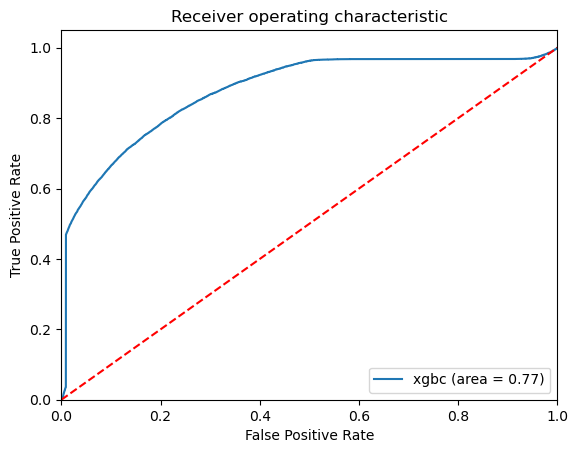

In [263]:

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_logistic_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

# print(precision_recall_curve_plot(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, best_final_logistic_regression.predict(test_model_predictions))
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Decision Tree Classifier

In [266]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
final_lr_model = DecisionTreeClassifier()

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(1, 11)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
}

random_search = RandomizedSearchCV(final_lr_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit the model using random search
random_search.fit(train_model_predictions, y_smote)

# Print the best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Get the best Decision Tree Classifier
best_dtc = random_search.best_estimator_

best_final_dtr_regression = random_search.best_estimator_

Best parameters found:
{'min_samples_split': 9, 'min_samples_leaf': 10, 'max_depth': 7, 'criterion': 'entropy'}


In [267]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_dtr_regression = random_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_dtr_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_dtr_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

# y_pred_prob = best_final_dtr_regression.predict_proba(train_model_predictions)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_threshold = thresholds[np.argmax(f1_scores)]
# print("Best probability threshold:", best_threshold)
best_threshold = 0.83

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_dtr_train_pred = custom_predict(best_final_dtr_regression, train_model_predictions, best_threshold)
stack_dtr_test_pred = custom_predict(best_final_dtr_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.9785192544755387
Test Accuracy: 0.8671326143278906


In [268]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_dtr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_dtr_test_pred))

Precision at theshold 0.83 is :  0.9954397644840391
Precision at theshold 0.83 is :  0.7967294162388286


In [269]:
pd.array(y_test)

<PandasArray>
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
 ...
 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Length: 82985, dtype: int64

Precision at theshold 0.83 is :  0.7967294162388286




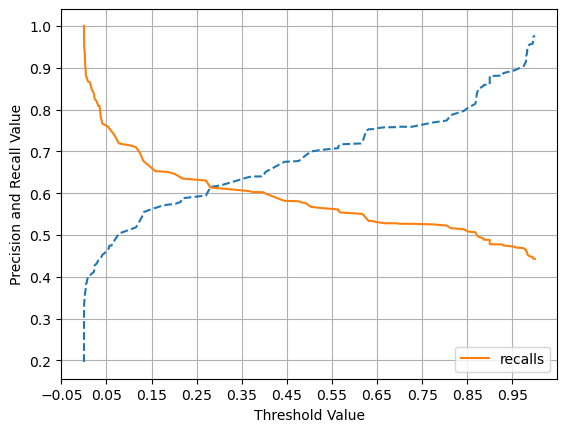

None

fbeta score : beta : 0.5 0.7176992514687998
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66676
           1       0.80      0.51      0.62     16309

    accuracy                           0.88     82985
   macro avg       0.84      0.74      0.78     82985
weighted avg       0.87      0.88      0.87     82985

0.8792890357787828


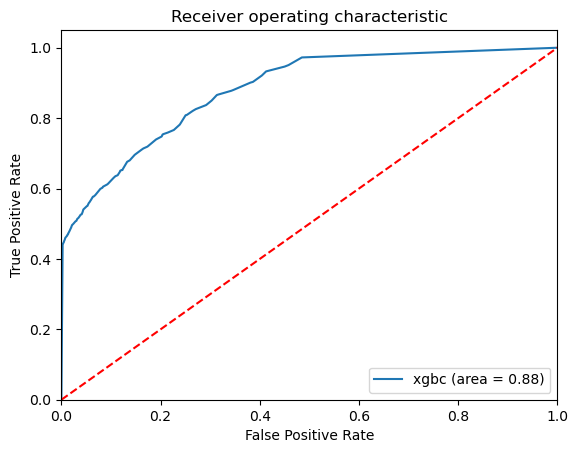

In [270]:
def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_dtr_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))


_roc_auc = roc_auc_score(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1])
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Mean of predictions

In [271]:
another_train_model = train_model_predictions.copy()

In [272]:
another_test_model = test_model_predictions.copy()

In [273]:
final_train_predictions = another_train_model.mean(axis=1)
final_test_predictions = another_test_model.mean(axis=1)


In [274]:
another_train_model

,logistic_l1,logistic_l2,xgb,lgbm
0,0.001067,1.398280e-21,0.019198,0.003782
1,0.999706,1.000000e+00,0.996962,0.999956
2,0.177413,1.679677e-01,0.035429,0.007159
3,0.000605,7.642927e-22,0.019194,0.003780
4,0.000747,1.049030e-21,0.019210,0.003780
...,...,...,...,...
326101,0.999711,1.000000e+00,0.996976,0.999957
326102,0.999683,1.000000e+00,0.996976,0.999957
326103,0.281475,2.662078e-01,0.996235,0.999956
326104,0.998797,1.000000e+00,0.996976,0.999957


In [275]:
def custom_predict(X, best_threshold):
    return (X > best_threshold).astype(int)

final_train_classifications = custom_predict(final_train_predictions, best_threshold)
final_test_classifications = custom_predict(final_test_predictions, best_threshold)

In [276]:
roc_auc_score(y_test, final_test_predictions)

0.9015959152682878

Precision at theshold 0.83 is :  0.9515885022692889


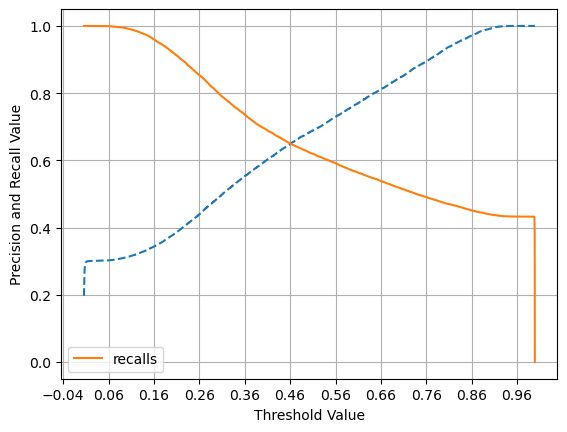

None
fbeta score : beta : 0.5 0.7856443991090201
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     66676
           1       0.95      0.46      0.62     16309

    accuracy                           0.89     82985
   macro avg       0.92      0.73      0.78     82985
weighted avg       0.90      0.89      0.87     82985

roc_auc score is 0.9015959152682878


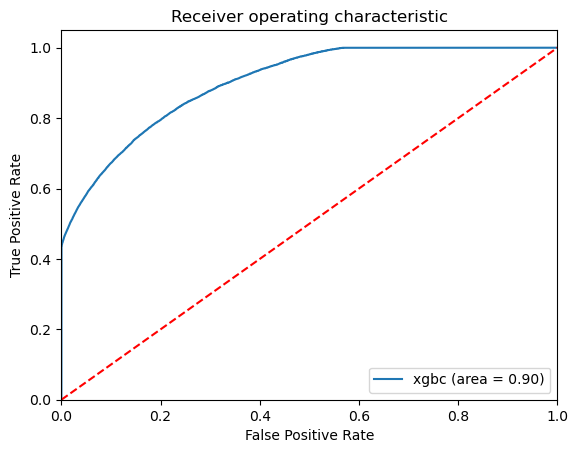

In [277]:
new_preds = final_test_classifications

print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,final_test_classifications))



print(precision_recall_curve_plot(y_test, final_test_predictions))
plt.show()



print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))


_roc_auc = roc_auc_score(y_test, final_test_predictions)
print('roc_auc score is ' + str(_roc_auc) )
fpr, tpr, thresholds = roc_curve(y_test, final_test_predictions)
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('mean_stacker')
plt.show()

In [278]:
X_train_null , X_test_null,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.3,
                                                      random_state=42)